# EX1 - Advanced ML 

---
<br>

### Name and ID:
Student 1: Ron Darmon, XXXXXXXXX
<br>
Student 2: Roei Arpaly, XXXXXXXXX

## General

### Imports & Utils

Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from plotly.subplots import make_subplots
from keras.datasets import mnist

# Load the dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

2023-05-26 12:26:13.195140: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Plotting utils

In [8]:
def components_scatter(x, y, labels, title, digits=False):
    
    n_clusters = np.max([np.max(labels) + 1, 1])
    palette = sns.color_palette('tab10' if n_clusters <= 10 else 'tab20', n_colors=n_clusters).as_hex()
    color_map = dict(enumerate(palette))
    
    fig = go.Figure()
    
    mode = 'text' if digits else 'markers'
    fig.add_trace(go.Scattergl(x=x, y=y, mode=mode,
                               text=labels.astype(str),
                               marker=dict(color=np.vectorize(color_map.get)(labels), colorscale=palette),
                               opacity=0.5,
                               showlegend=False))
    
    if digits:
        fig.for_each_trace(lambda t: t.update(textfont_color=t.marker.color, textposition='top center'))

    fig.update_layout(title=dict(text=title, x=.5, y=.95),
                      width=600, height=600, template="plotly_white",
                      xaxis=dict(title='Component 1', showgrid=False, zeroline=False),
                      yaxis=dict(title='Component 2', showgrid=False, zeroline=False),
                      )

    fig.show(renderer='png')

In [9]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap

def digits_scatter(data, embedded_data, clusters=None):

    fig, ax = plt.subplots(figsize=(10, 10))

    for i, row in embedded_data.iterrows():
        image = data[i].reshape((28, 28))
        
        # Convert the image to RGBA with a transparent background
        rgba_image = np.zeros((28, 28, 4))
        if clusters is not None:
            n_clusters = np.max([np.max(clusters) + 1, 1])
            palette = sns.color_palette('tab10' if n_clusters <= 10 else 'tab20', n_colors=n_clusters).as_hex()
            color_index = clusters[i]
            rgba_image = LinearSegmentedColormap.from_list("", ['#FFFFFF', palette[color_index]])(image)
        else:
            rgba_image = plt.cm.Greys(image)
        rgba_image[:, :, 3] = (image > 0).astype(np.uint8)

        im = OffsetImage(rgba_image, zoom=0.5)
        ab = AnnotationBbox(im, (row[0], row[1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(row[0], row[1])])
        ax.autoscale()
    ax.axis('off')

In [10]:
def variance_explained(transformer):
    
    y = transformer.explained_variance_ratio_ * 100
    x = np.arange(len(y)) + 1
    
    palette = sns.color_palette('tab10').as_hex()
    
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(x=x, y=y.cumsum(),
                             mode='lines+markers+text',
                             texttemplate='%{y:.1f}%',
                             hovertemplate='%{y:.2f}',
                             textposition= 'top center',
                             textfont=dict(color=palette[0], size=12),
                             name='Cumulative Variance Explained',
                             line=dict(color=palette[0], width=2),
                             ))

    fig.add_trace(go.Bar(x=x, y=y,
                         hovertemplate='%{y:.2f}',
                         name='Variance Explained',
                         marker_color=palette[1],
                         ))
    
    if isinstance(transformer, PCA):
        title = "PCA "
    elif isinstance(transformer, LinearDiscriminantAnalysis):
        title = "LDA "
    else:
        title = ""

    fig.update_layout(title=dict(text=title + 'Variance Explained', x=0.5, y=0.9, font=dict(size=18)),
                      height=600, width=1400,
                      xaxis=dict(title='PC', showgrid=False, dtick=1, range=[0.5, max(x) + 0.5]),
                      yaxis=dict(title_text='Percent', ticksuffix='%'),
                      legend=dict(orientation='h', yanchor='bottom', y=0.99, x=0.5, xanchor='center'),
                      hovermode='x unified',
                      hoverlabel_align='right',
                      template='plotly_white',
                      )
    fig.show(renderer='png')

In [11]:
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics.cluster import adjusted_mutual_info_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler

def cluster_evaluation(X, y, y_pred):
     
    test_silhouette = round(silhouette_score(X, y_pred, n_jobs=-1), 4)
    test_ars = round(adjusted_rand_score(y, y_pred), 4)
    ami = round(adjusted_mutual_info_score(y, y_pred), 4)
    nmi = round(normalized_mutual_info_score(y, y_pred), 4)
    
    print(f'Testing silhouette score: {test_silhouette}')
    print(f'Testing adjusted rand score: {test_ars}')
    print(f'Testing adjusted mutual info score score: {ami}')
    print(f'Testing normalized mutual info score rand score: {nmi}')    

---

### EDA

First lets have a look of how some random digits are drawn

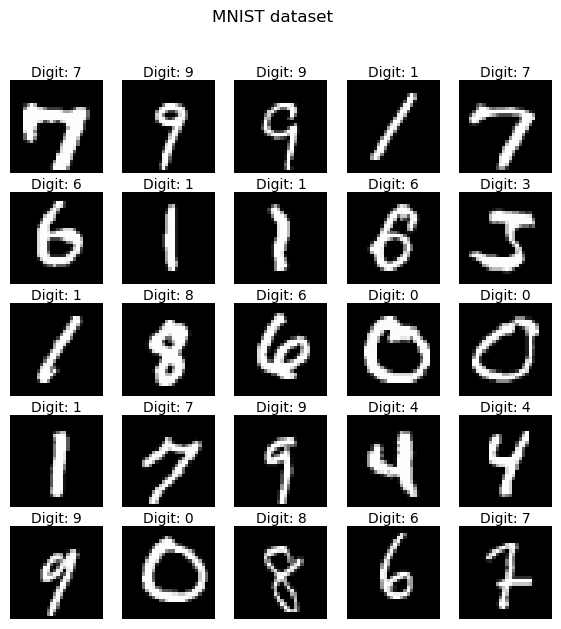

In [12]:
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows=nrows, ncols=nrows, figsize=(7, 7))

for ax in axes.flatten():
    index = np.random.randint(0, X_train.shape[0])
    image = X_train[index]
    ax.imshow(image, cmap='gray')
    ax.set_title(f"Digit: {y_train[index]}", pad=0, fontsize=10)
    ax.axis('off')

fig.suptitle("MNIST dataset");

---
Now lets plot the distribution of the labels 

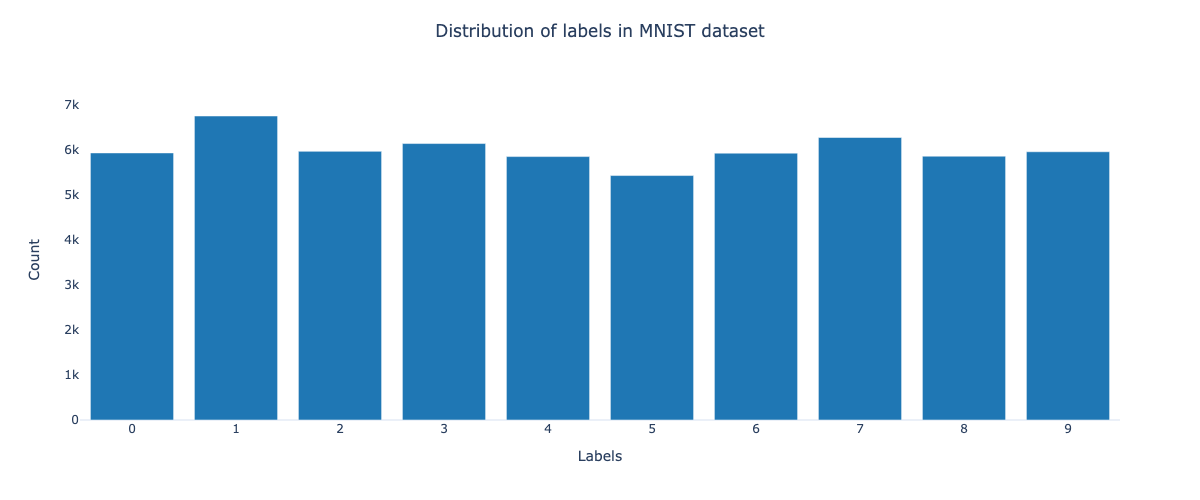

In [13]:
unique, counts = np.unique(y_train, return_counts=True)
label_distribution = dict(zip(unique, counts))

fig = go.Figure()
fig.add_trace(go.Bar(x=list(label_distribution.keys()), 
                     y=list(label_distribution.values()),
                     marker_color='#1f77b4'
                     )
              )

fig.update_layout(title=dict(text='Distribution of labels in MNIST dataset', x=0.5, y=0.95),
                  width=1200, height=500, template="plotly_white",
                  xaxis=dict(title='Labels', showgrid=False, dtick=1),
                  yaxis=dict(title='Count', showgrid=False, tickformat ='.1s'),
                  )
fig.show(renderer='png')


---

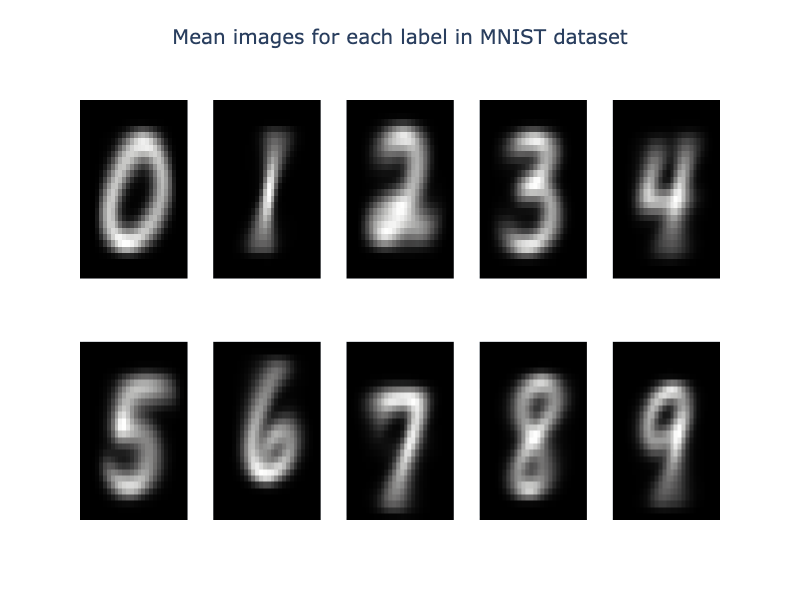

In [14]:
mean_images = []
for label in range(10):
    label_images = X_train[y_train == label]
    mean_image = np.mean(label_images, axis=0)[::-1]
    mean_images.append(mean_image)

fig = make_subplots(rows=2, cols=5)
for i in range(10):
    row = i // 5 + 1
    col = i % 5 + 1
    fig.add_trace(
        go.Heatmap(z=mean_images[i], colorscale='gray', showscale=False, name=f'Number: {i}'),
        row=row, col=col
    )

fig.update_layout(height=600, width=800, title_x=0.5, showlegend=True,
                  title=dict(text='Mean images for each label in MNIST dataset',
                             x=0.5, y=0.95, font=dict(size=20)))
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.show(renderer='png')

---
Now lets plot the mean for each label to get an idea of what each label looks like

To infer the clustering algorithms we first implemented dimensionality reduction

## Part 2: Dimensionality Reduction

Preprocess

In [15]:
# Treat the data as tabular 28*28 = 784 features
X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)

Subsampling

To work with algorithms which are computational heavy (such as Isomap),
we decided to subsample the dataset - using the 10,000 first samples (we checked if the data is shuffled and if the digits are balanced in this subset).

In [16]:
# Number of samples for taking a subset of X_train, when needed
n_samples = 10_000

Scaling

In [17]:
# MinMaxScaler may be used when the upper and lower boundaries are well known from domain knowledge (e.g. pixel intensities that go from 0 to 255 in the RGB color range).

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

We will use X_test for dimensionality reduction as it contains lower amount of samples, which are easier to visualise and reduce computation needed.

### T-SNE

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=10, random_state=0, n_jobs=-1)
X_embedded = tsne.fit_transform(X_train_scaled[:n_samples])

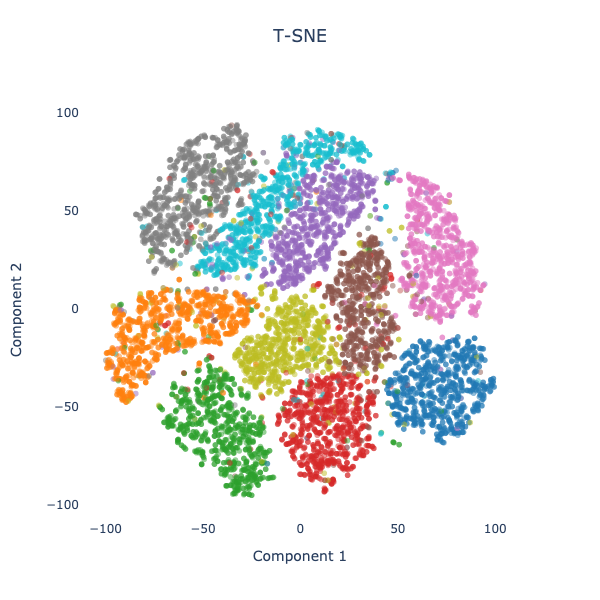

In [19]:
components_scatter(x=X_embedded[:,0], y=X_embedded[:,1], labels=y_train[:n_samples], title='T-SNE')

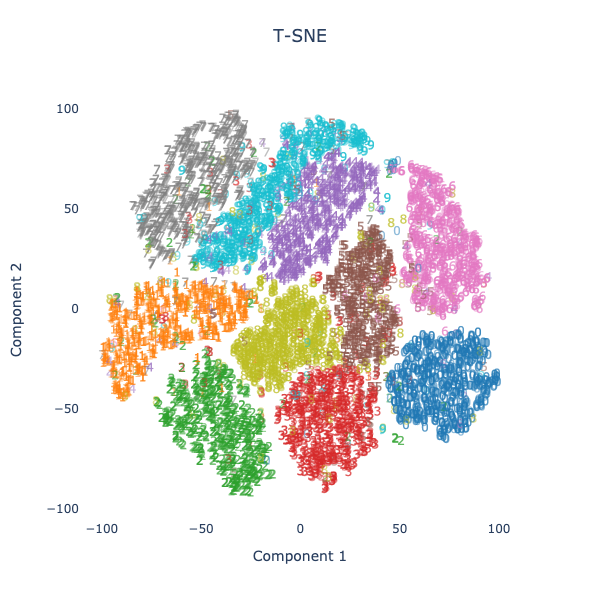

In [20]:
components_scatter(x=X_embedded[:,0], y=X_embedded[:,1], labels=y_train[:n_samples], title='T-SNE', digits=True)

Examine the data without labels

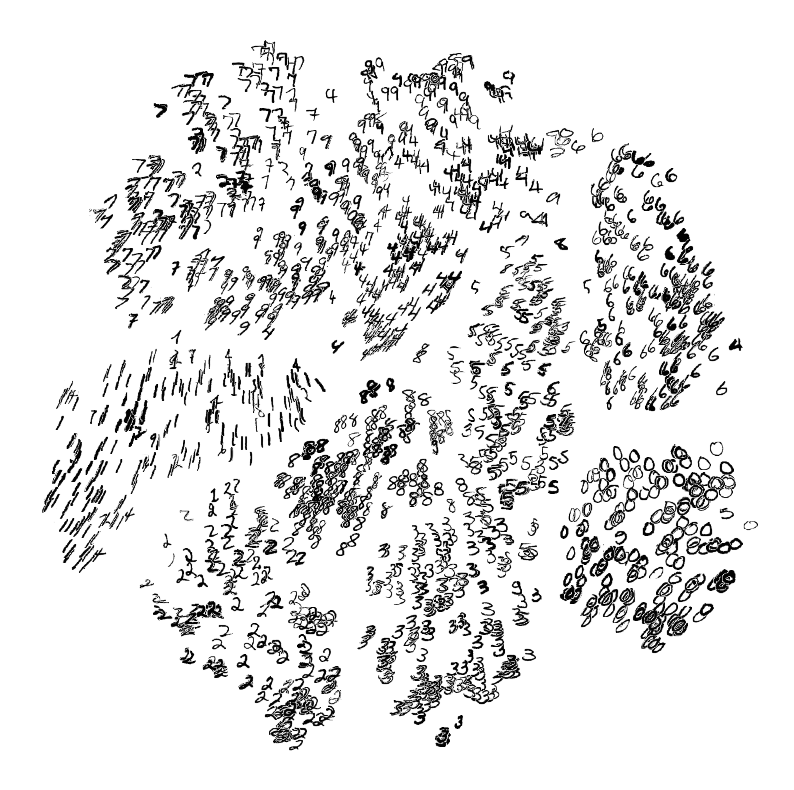

In [21]:
df_subset = pd.DataFrame(data=X_embedded).iloc[:2000]
digits_scatter(data=X_train_scaled[:n_samples], embedded_data=df_subset)

Examine the data with labels

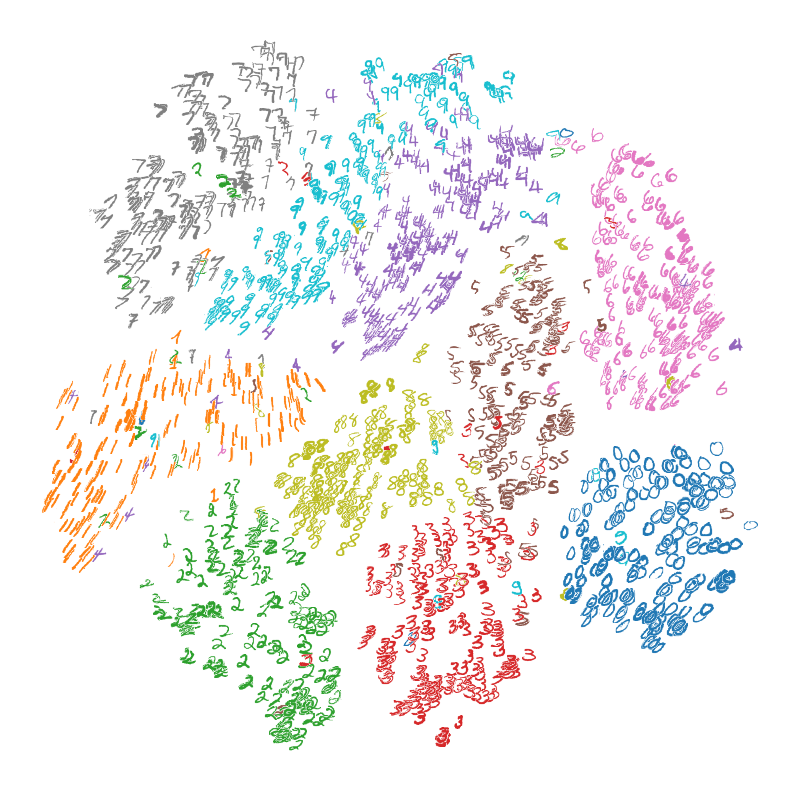

In [22]:
digits_scatter(data=X_train_scaled[:n_samples], embedded_data=df_subset, clusters=y_train[:n_samples])

Examining Different Perplexity

In [23]:
tsne = TSNE(n_components=2, perplexity=5, random_state=0, n_jobs=-1)
X_embedded = tsne.fit_transform(X_train_scaled[:n_samples])

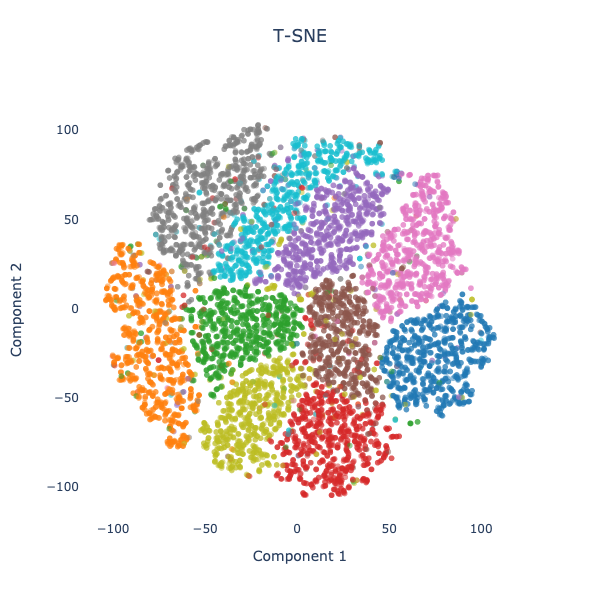

In [24]:
components_scatter(x=X_embedded[:,0], y=X_embedded[:,1], labels=y_train[:n_samples], title='T-SNE')

#### Train classifier based on T-SNE

Steps:

1.   We use T-SNE for partial training data (computational expensive)
2.   We train a classifier on X embedded data after using T-SNE
3.   T-SNE doesn't supply transform method, therefore we first find a similar neighbors in the original space, and then take their indices to find out their average value in the reduced dimension.
4.   The prediction is based on those new values (5NN AVG in T-SNE space).

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors

rf_clf = RandomForestClassifier()
rf_clf.fit(X_embedded, y_train[:n_samples])

nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_train_scaled[:n_samples])
neigh_dist, neigh_ind = nn.kneighbors(X_test_scaled)

X_test_embedded = np.take(X_embedded, neigh_ind, axis=0).mean(axis=1)
y_pred = rf_clf.predict(X_test_embedded)

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.93      0.99      0.96      1135
           2       0.84      0.85      0.85      1032
           3       0.88      0.88      0.88      1010
           4       0.88      0.85      0.87       982
           5       0.87      0.88      0.87       892
           6       0.96      0.97      0.96       958
           7       0.93      0.90      0.91      1028
           8       0.87      0.77      0.81       974
           9       0.82      0.88      0.85      1009

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



---

### PCA

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
X_embedded = pca.fit_transform(X_train_scaled)

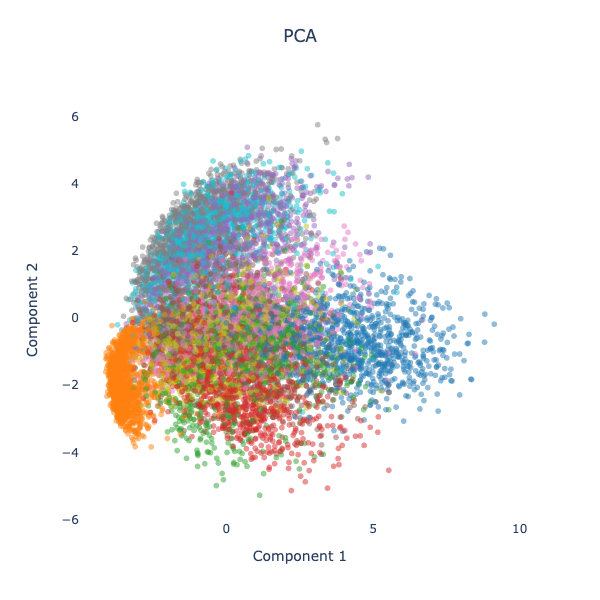

In [28]:
components_scatter(x=X_embedded[:n_samples,0], y=X_embedded[:n_samples,1], labels=y_train[:n_samples], title='PCA')

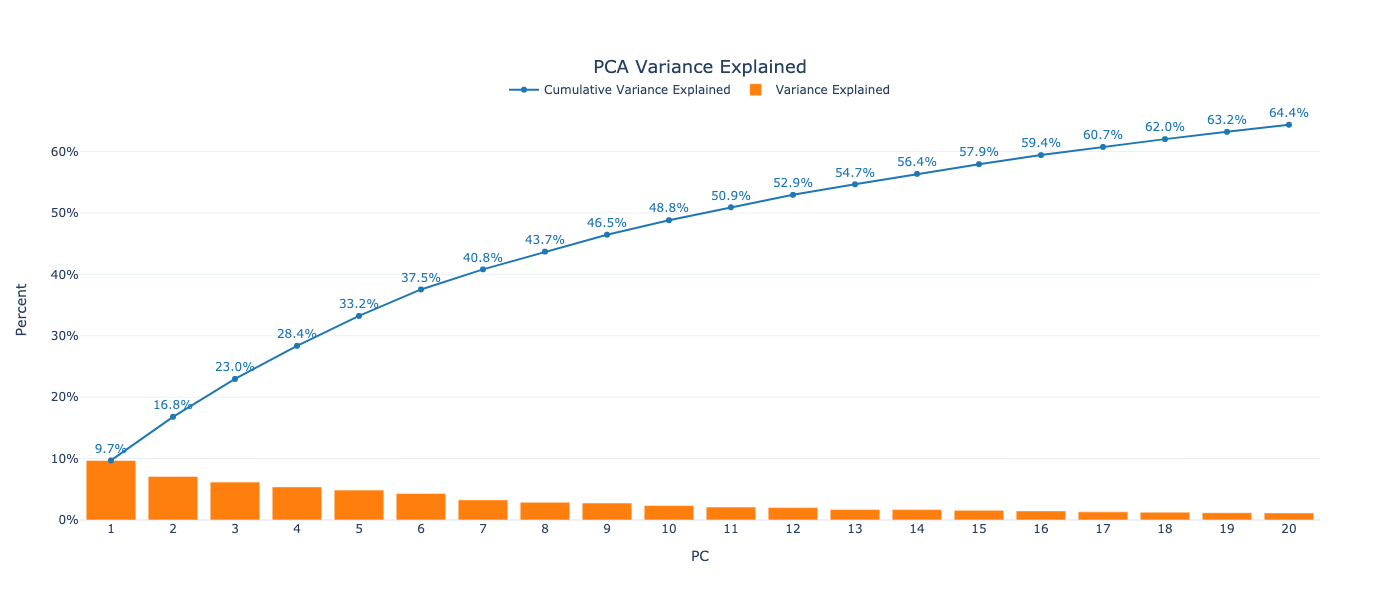

In [29]:
variance_explained(transformer=pca)

#### Train classifier based on PCA

In [30]:
rf_clf = RandomForestClassifier()

rf_clf.fit(X_embedded, y_train)

X_test_embedded = pca.transform(X_test_scaled)
y_pred = rf_clf.predict(X_test_embedded)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.94      0.94      1032
           3       0.93      0.94      0.94      1010
           4       0.94      0.94      0.94       982
           5       0.93      0.93      0.93       892
           6       0.96      0.98      0.97       958
           7       0.96      0.94      0.95      1028
           8       0.92      0.91      0.92       974
           9       0.92      0.91      0.91      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



---

### Isomap

Dimensionality reduction with sample of X_train (fitting all of the observations doesn't fit into memory)

In [32]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2, n_jobs=-1)
X_embedded = isomap.fit_transform(X_train_scaled[:n_samples])

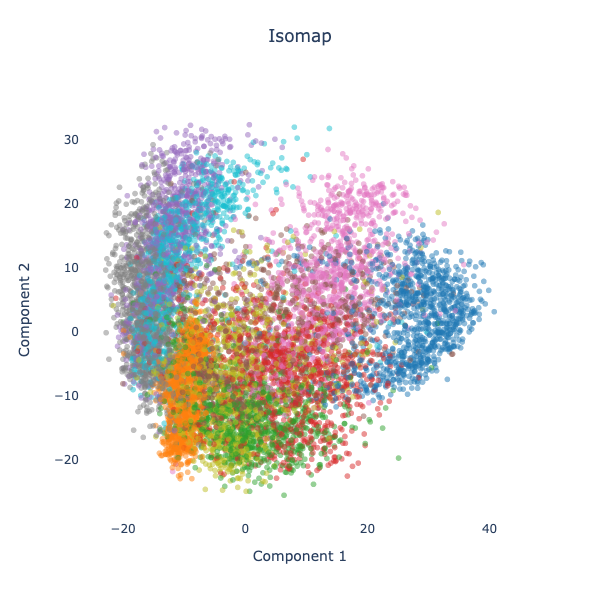

In [33]:
components_scatter(x=X_embedded[:n_samples,0], y=X_embedded[:n_samples,1], labels=y_train[:n_samples], title='Isomap')

Isomap with manhatthan distance

In [34]:
isomap = Isomap(n_components=2, n_neighbors=5, p=1, n_jobs=-1)  # p=1 is manhattan distance
X_embedded = isomap.fit_transform(X_train_scaled[:n_samples])

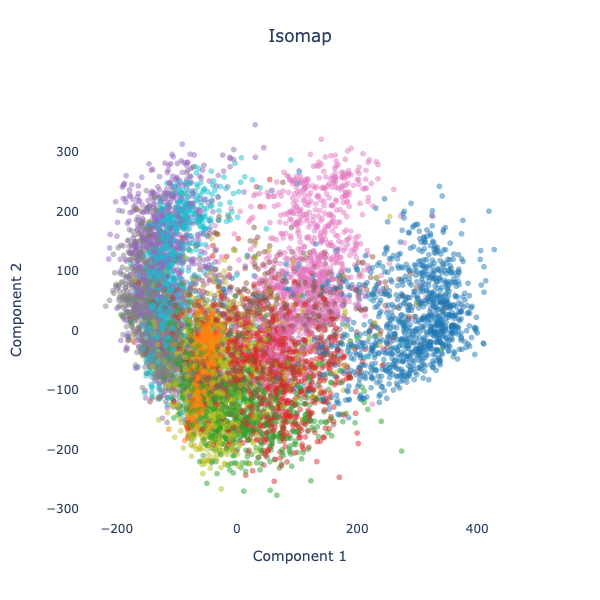

In [35]:
components_scatter(x=X_embedded[:n_samples,0], y=X_embedded[:n_samples,1], labels=y_train[:n_samples], title='Isomap')

Isomap with large number of neighbors

In [36]:
isomap = Isomap(n_components=2, n_neighbors=30, n_jobs=-1)
X_embedded = isomap.fit_transform(X_train_scaled[:n_samples])

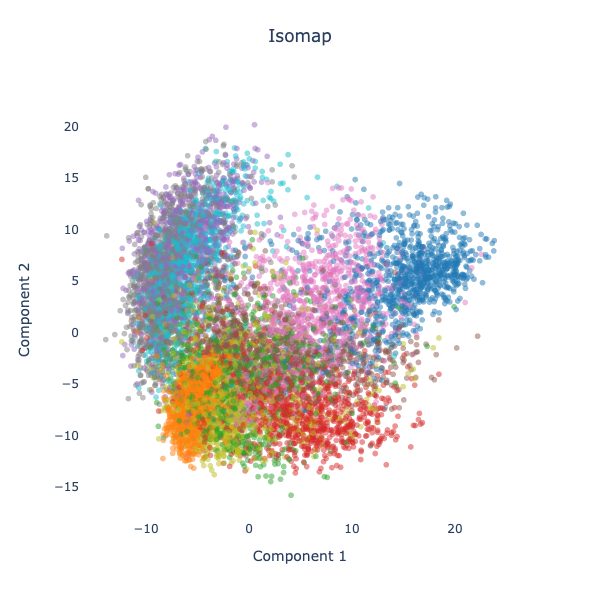

In [37]:
components_scatter(x=X_embedded[:n_samples,0], y=X_embedded[:n_samples,1], labels=y_train[:n_samples], title='Isomap')

#### Train classifier based on Isomap

In [38]:
rf_clf = RandomForestClassifier()

rf_clf.fit(X_embedded, y_train[:n_samples])

X_test_embedded = isomap.transform(X_test_scaled)
y_pred = rf_clf.predict(X_test_embedded)

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.79      0.77       980
           1       0.69      0.92      0.79      1135
           2       0.32      0.24      0.28      1032
           3       0.58      0.61      0.59      1010
           4       0.32      0.31      0.31       982
           5       0.45      0.35      0.39       892
           6       0.51      0.56      0.54       958
           7       0.42      0.54      0.47      1028
           8       0.32      0.22      0.26       974
           9       0.37      0.33      0.35      1009

    accuracy                           0.49     10000
   macro avg       0.47      0.49      0.47     10000
weighted avg       0.47      0.49      0.48     10000



---

### LDA

Supervised Dimensionality Reduction

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n_components = len(np.unique(y_train)) - 1
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_embedded = lda.fit_transform(X_train_scaled, y_train)

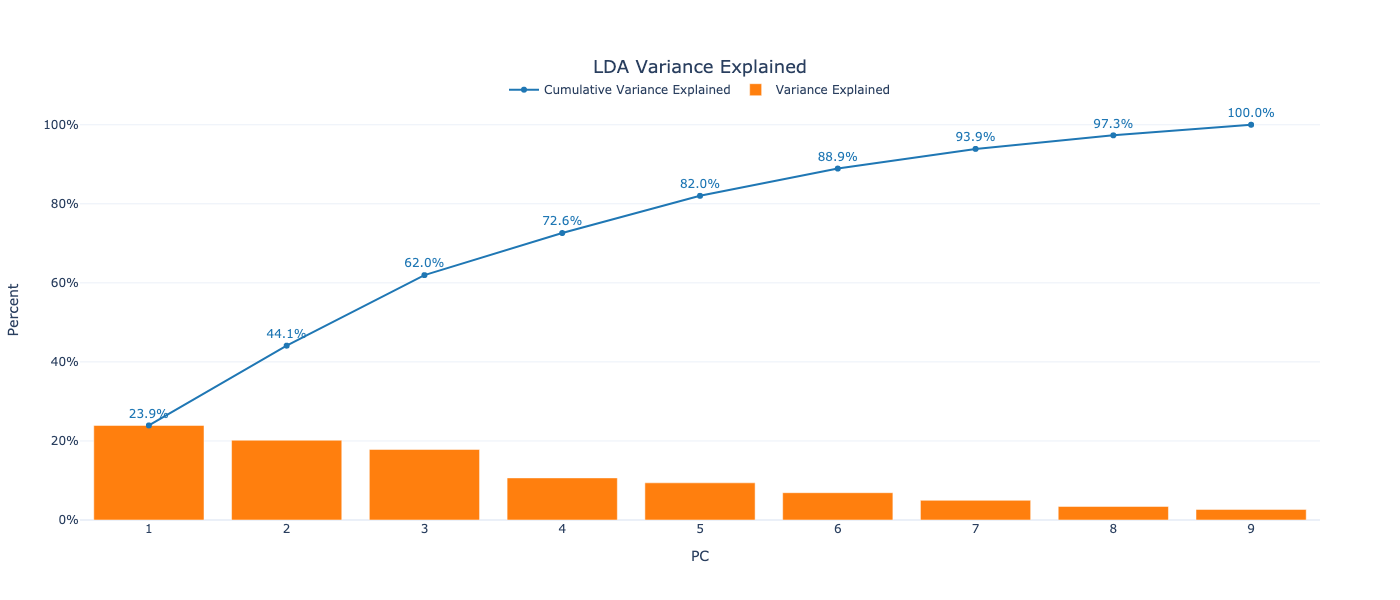

In [41]:
variance_explained(transformer=lda)

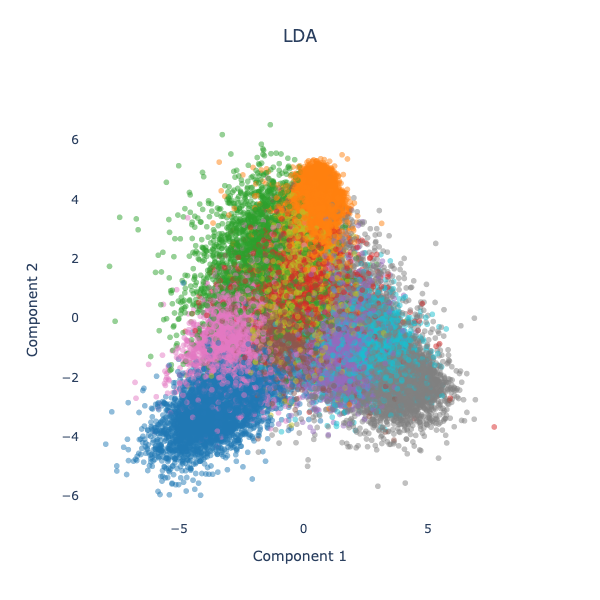

In [42]:
components_scatter(x=X_embedded[:,0], y=X_embedded[:,1], labels=y_train, title='LDA')

#### Train classifier based on LDA

In [43]:
rf_clf = RandomForestClassifier()

rf_clf.fit(X_embedded, y_train)

X_test_embedded = lda.transform(X_test_scaled)
y_pred = rf_clf.predict(X_test_embedded)

In [44]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.96      0.97      0.97      1135
           2       0.92      0.90      0.91      1032
           3       0.88      0.89      0.89      1010
           4       0.90      0.93      0.91       982
           5       0.88      0.86      0.87       892
           6       0.94      0.94      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.87      0.86      0.86       974
           9       0.92      0.88      0.90      1009

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



---

## Part 1: Clustering

##### Benchmarking

Supervised

In [45]:
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train_scaled, y_train)

y_pred = rf_clf.predict(X_test_scaled)

In [46]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.9697

Dummy

In [47]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_scaled, y_train)
y_pred = dummy_clf.predict(X_test_scaled)

In [48]:
accuracy_score(y_test, y_pred)

0.1135

Selecting T-SNE, which was the most clear data representation in lower dimension to visualise the clusters (df_subset)

### K-means

Now we can color the samples based on the predicted cluster

In [49]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, n_init="auto", random_state=0)
y_pred = kmeans.fit_predict(X_train_scaled)

In [50]:
cluster_evaluation(X=X_train_scaled, y=y_train, y_pred=y_pred)

Testing silhouette score: 0.0503
Testing adjusted rand score: 0.3197
Testing adjusted mutual info score score: 0.4523
Testing normalized mutual info score rand score: 0.4525


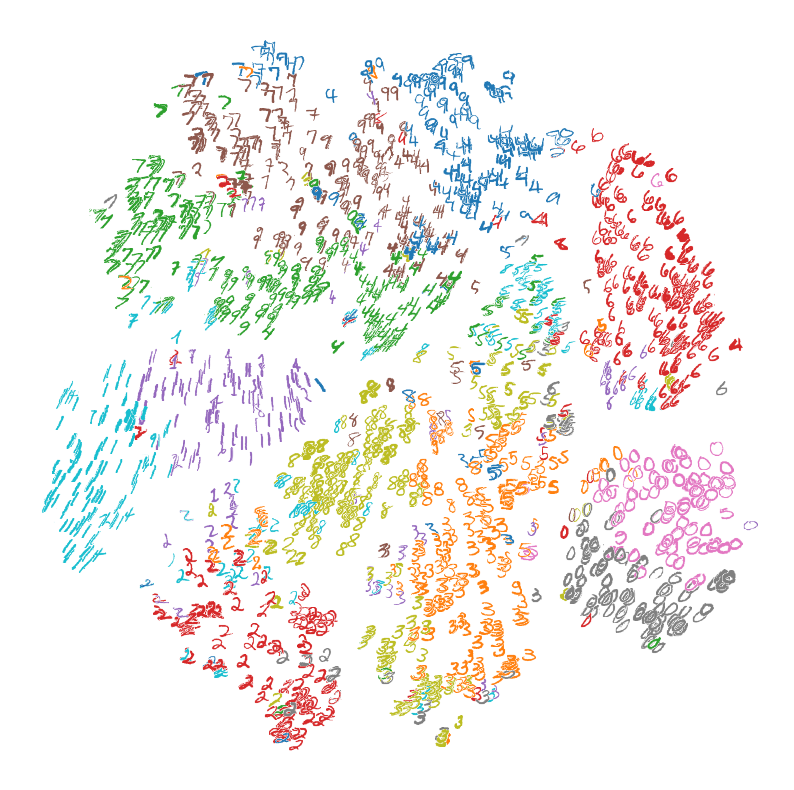

In [51]:
digits_scatter(data=X_train_scaled, embedded_data=df_subset, clusters=y_pred)

#### Train a classifier based on K-means

Unsupervised

Manually generate labels based on the clustering result (match with the colors)

In [52]:
sns.color_palette('tab10', n_colors=10)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [53]:
mapping = dict(enumerate([4, 3, 7, 6, 1, 9, 0, 0, 8, 1]))
y_train_labels = np.vectorize(mapping.get)(y_pred)

Train a classifier on X_train and the new y generated labels

In [54]:
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train_scaled, y_train_labels)

y_pred = rf_clf.predict(X_test_scaled)

In [55]:
print(classification_report(y_test, y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       980
           1       0.68      0.99      0.81      1135
           2       1.00      0.00      0.00      1032
           3       0.49      0.71      0.58      1010
           4       0.45      0.35      0.39       982
           5       1.00      0.00      0.00       892
           6       0.51      0.89      0.65       958
           7       0.41      0.40      0.41      1028
           8       0.53      0.62      0.57       974
           9       0.35      0.45      0.40      1009

    accuracy                           0.54     10000
   macro avg       0.63      0.53      0.47     10000
weighted avg       0.63      0.54      0.48     10000



We can see the classifier has low performance predicting the label "4", due to the clustering results.

We evaluate the results with y_test.<br>In fully unsupervised approach we won't be able to evalute the classification results with y_test.<br>Still, we can generate labels ourselves for the test set as well, in the same procedure for the evaluation.<br>This approach can be valid only if we feel confidence with the clustering results.

### DBSCAN

In [56]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=5, min_samples=10, n_jobs=-1)
y_pred = dbscan.fit_predict(X_train_scaled)

In [57]:
cluster_evaluation(X=X_train_scaled, y=y_train, y_pred=y_pred)

Testing silhouette score: -0.1368
Testing adjusted rand score: 0.0575
Testing adjusted mutual info score score: 0.1177
Testing normalized mutual info score rand score: 0.1186


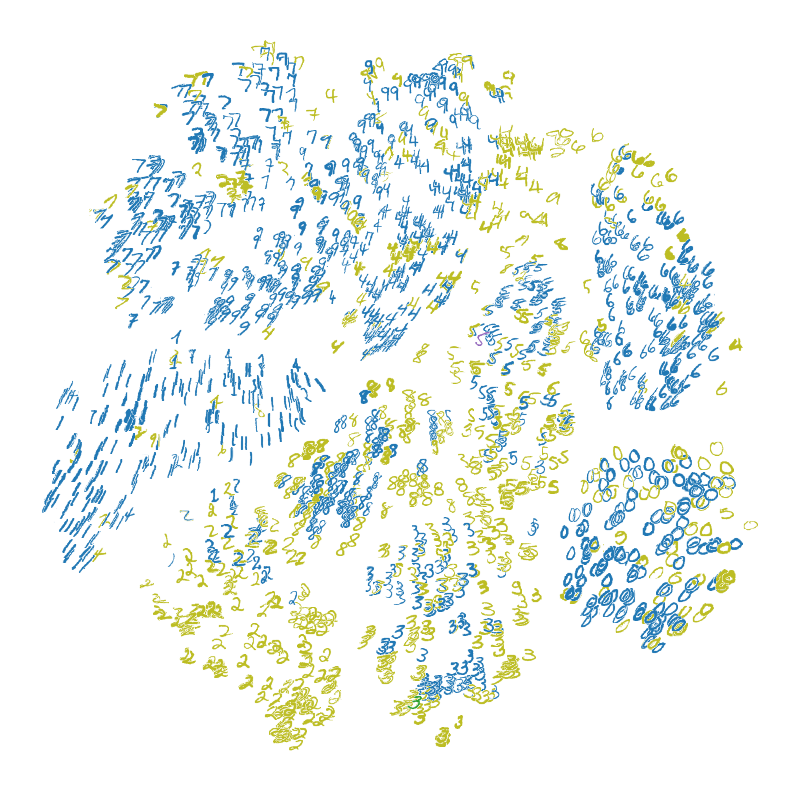

In [58]:
digits_scatter(data=X_train_scaled, embedded_data=df_subset, clusters=y_pred)

We tried various hyperparameters (eps, min_samples) and didn't manage to get a reasonable clustering result.
Therefore we decided not to train a classifier based on DBSCAN clustering.

### AgglomerativeClustering

Create the clusters with sample of X_train (training with all observations doesn't fit into memory)

In [59]:
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(n_clusters=10)
y_pred = clusterer.fit_predict(X_train_scaled[:n_samples])

In [60]:
cluster_evaluation(X=X_train_scaled[:n_samples], y=y_train[:n_samples], y_pred=y_pred)

Testing silhouette score: 0.033
Testing adjusted rand score: 0.5214
Testing adjusted mutual info score score: 0.6619
Testing normalized mutual info score rand score: 0.6625


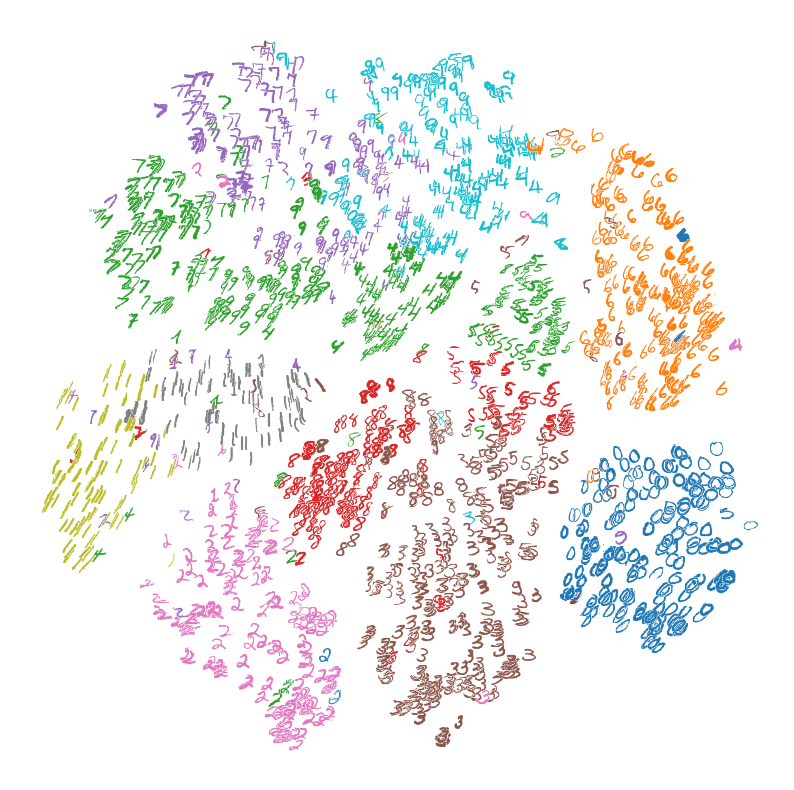

In [61]:
digits_scatter(data=X_train_scaled, embedded_data=df_subset, clusters=y_pred)

Selecting higher number of clusters

In [62]:
clusterer = AgglomerativeClustering(n_clusters=14)
y_pred = clusterer.fit_predict(X_train_scaled[:n_samples])

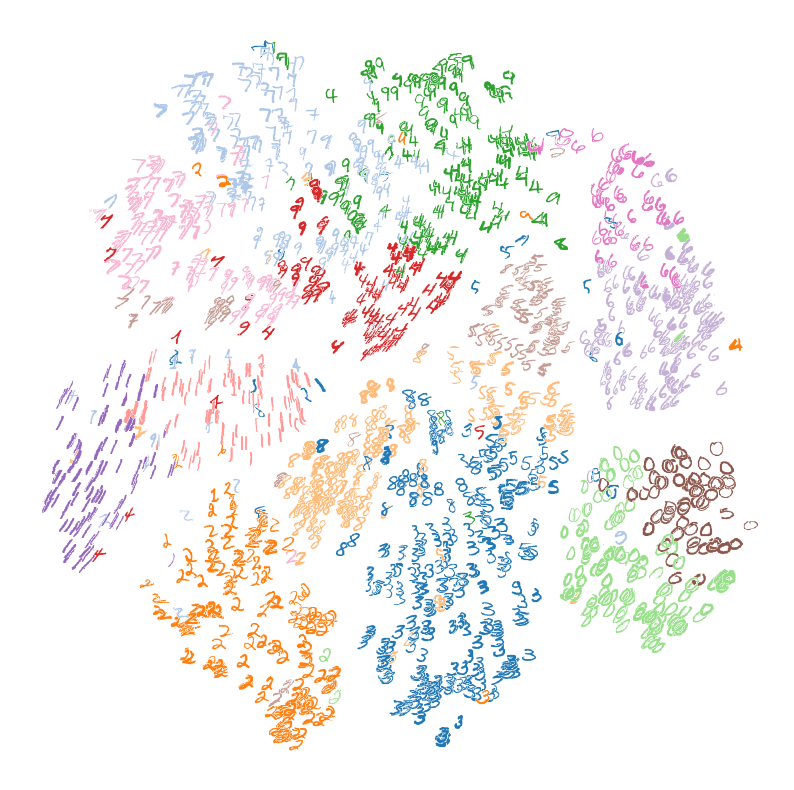

In [63]:
digits_scatter(data=X_train_scaled, embedded_data=df_subset, clusters=y_pred)

#### Train a classifer based on AgglomerativeClustering

Unsupervised

Manually generate labels based on the clustering result (match with the colors)

In [64]:
sns.color_palette('tab20', n_colors=14)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058)]

In [65]:
mapping = dict(enumerate([3, 7, 2, 8, 4, 0, 4, 1, 1, 6, 0, 5, 6, 7]))
y_train_labels = np.vectorize(mapping.get)(y_pred)

Train a classifier on X_train and the new y generated labels

In [66]:
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train_scaled[:n_samples], y_train_labels)

y_pred = rf_clf.predict(X_test_scaled)

In [67]:
print(classification_report(y_test, y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.98      0.99      0.98      1135
           2       0.95      0.91      0.93      1032
           3       0.57      0.96      0.71      1010
           4       0.53      0.85      0.65       982
           5       0.76      0.24      0.37       892
           6       0.95      0.96      0.95       958
           7       0.64      0.90      0.75      1028
           8       0.66      0.61      0.64       974
           9       1.00      0.00      0.00      1009

    accuracy                           0.75     10000
   macro avg       0.80      0.74      0.70     10000
weighted avg       0.80      0.75      0.70     10000



We evaluate the results with y_test.<br>In fully unsupervised approach we won't be able to evalute the classification results with y_test.<br>Still, we can generate labels ourselves for the test set as well, in the same procedure for the evaluation.<br>This approach can be valid only if we feel confidence with the clustering results.

### GMM

In [68]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, random_state=0)
y_pred = gmm.fit_predict(X_train_scaled[:n_samples])

In [69]:
cluster_evaluation(X=X_train_scaled[:n_samples], y=y_train[:n_samples], y_pred=y_pred)

Testing silhouette score: 0.0481
Testing adjusted rand score: 0.3863
Testing adjusted mutual info score score: 0.5103
Testing normalized mutual info score rand score: 0.5112


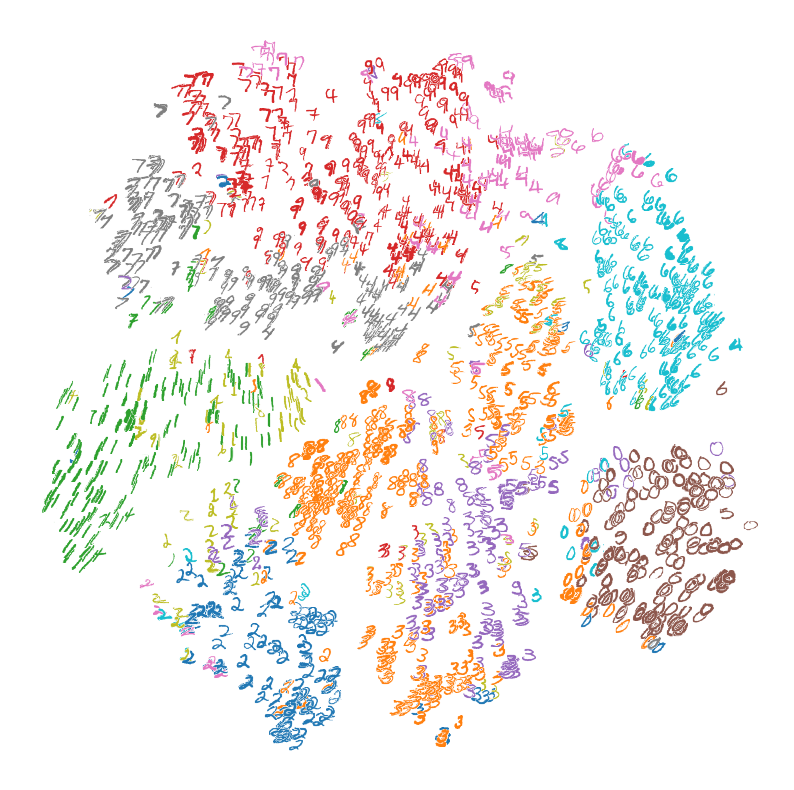

In [70]:
digits_scatter(data=X_train_scaled, embedded_data=df_subset, clusters=y_pred)

#### Train a classifer based on GMM

Unsupervised

Manually generate labels based on the clustering result (match with the colors)

In [71]:
sns.color_palette('tab10', n_colors=10)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [72]:
mapping = dict(enumerate([2, 8, 1, 9, 3, 0, 4, 7, 1, 6]))
y_train_labels = np.vectorize(mapping.get)(y_pred)

Train a classifier on X_train and the new y generated labels

In [73]:
rf_clf = RandomForestClassifier(n_jobs=-1)
rf_clf.fit(X_train_scaled[:n_samples], y_train_labels)

y_pred = rf_clf.predict(X_test_scaled)

In [74]:
print(classification_report(y_test, y_pred, zero_division=True))

              precision    recall  f1-score   support

           0       0.94      0.82      0.88       980
           1       0.75      0.99      0.86      1135
           2       0.93      0.62      0.75      1032
           3       0.50      0.47      0.48      1010
           4       0.39      0.20      0.26       982
           5       1.00      0.00      0.00       892
           6       0.91      0.82      0.86       958
           7       0.44      0.38      0.41      1028
           8       0.36      0.73      0.48       974
           9       0.37      0.65      0.47      1009

    accuracy                           0.58     10000
   macro avg       0.66      0.57      0.55     10000
weighted avg       0.66      0.58      0.55     10000



---

## Part 3: Classification of the raw data

In [75]:
from sklearn.svm import SVC

svc = SVC(gamma='scale', class_weight='balanced', C=100)
svc.fit(X_train_scaled, y_train)

y_pred = svc.predict(X_test_scaled)

Evaluation

In [76]:
from sklearn.metrics import ConfusionMatrixDisplay

print(f'Accuracy : {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy : 0.9833
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



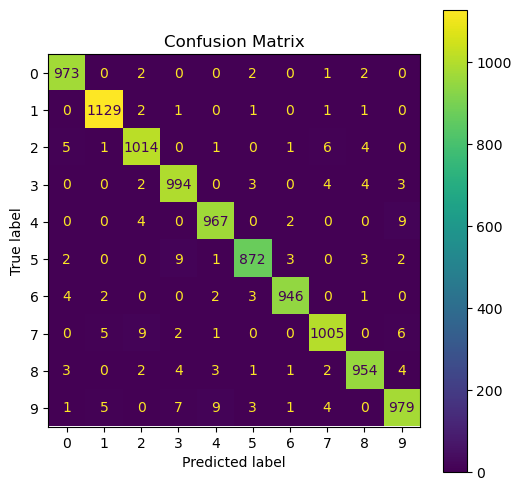

In [77]:
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
ax.set_title("Confusion Matrix");

GridSearch

In [78]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit

param_grid = {
    'C': [1, 100],
    'kernel': ['rbf'],
    'degree': [3],
    'gamma': ['scale'],
    'class_weight': ['balanced'],
}

ss = ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
svc_grid = GridSearchCV(SVC(), param_grid, cv=ss, scoring='accuracy', refit='accuracy', n_jobs=-1)
svc_grid.fit(X_train_scaled, y_train)
y_pred = svc_grid.predict(X_test_scaled)

GridSearch Evaluation

In [79]:
print(f'Accuracy : {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))

Accuracy : 0.9833
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



---

Part 4: Summary - In the PDF